In [1]:
EPOCH = 'Training Epoch'
CROP_SIZE = 'Crop size'
PROC = 'Procedure'
COCO_AP = 'COCO AP'
COCO_AP_BIN = 'COCO AP (binary clf)'
RECOG_AP = 'mAP'

In [2]:
PROC_1 = "Proc. 1"# (Conventional detector training)"
PROC_2 = "Proc. 2"# (Two-phase training)"
PROC_3 = "Proc. 3"# (Crop batch training)"
PROC_4 = "Proc. 4"# (Task-specific training)"

In [3]:
from pathlib import Path

import pandas as pd
from tqdm.notebook import tqdm
import wandb


res_path = Path('procedure_results.pkl')
LAZY = True


def get_results():
    api = wandb.Api()

    SWEEPS = {
        "experiments/310owxsf": PROC_1,
        "experiments/19ngalv7": PROC_2,
        "experiments/hk6gkywa": PROC_3,
        "experiments/50xjrlu4": PROC_4,
    }

    results = []

    for sweep_suffix, proc_name in tqdm(SWEEPS.items()):
        sweep = api.sweep(f"jpdr/{sweep_suffix}")
        runs = sweep.runs

        for run in tqdm(runs, leave=False):
            df_history = run.history(keys=[
                "COCO_recog/AP@[0.50:0.95]",
                "epoch",
            ])
            df_history = pd.concat([
                df_history,
                run.history(keys=[
                    "COCO_detect/AP@[0.50:0.95]",
                    "epoch",
                ])
            ])
            df_history = pd.concat([
                df_history,
                run.history(keys=[
                    "AggPRCurve/mAP",
                    "epoch",
                ])
            ])
            df_history[PROC] = proc_name
            df_history[CROP_SIZE] = run.config['crop_box_size']
            df_history['val_fold'] = run.config['k_fold_val_fold']
            results.append(df_history)

    df = pd.concat(results, ignore_index=True)
    return df


if not res_path.exists() or not LAZY:
    df = get_results()
    df.to_pickle(res_path)
else:
    df = pd.read_pickle(res_path)


df = df.rename(columns={
    'epoch': EPOCH,
    'COCO_recog/AP@[0.50:0.95]': COCO_AP,
    "COCO_detect/AP@[0.50:0.95]": COCO_AP_BIN,
    "AggPRCurve/mAP": RECOG_AP,
})

In [4]:
PROCS_3_4 = []

crop_sizes_names = [
    s for s in df[CROP_SIZE].unique()
]
crop_sizes_names = sorted(crop_sizes_names, reverse=True)


for i, size in enumerate(crop_sizes_names):
    size = int(size)
    char = 'ABCDEFG'[i]
    new_proc = f'{PROC_3[:7]}{char}{PROC_3[7:-1]}, {size}px'
    PROCS_3_4.append(new_proc)
    df.loc[(df[PROC] == PROC_3)
        & (df[CROP_SIZE] == size), PROC] = new_proc

PROCS_3_4.append(PROC_4)

df.loc[(df[PROC] == PROC_4), CROP_SIZE] = -1

In [5]:
fig_path = Path('./imgs')

In [6]:
df[df[CROP_SIZE].isin([800])]['Procedure'].unique()

array(['Proc. 1', 'Proc. 2', 'Proc. 3A, 800px'], dtype=object)

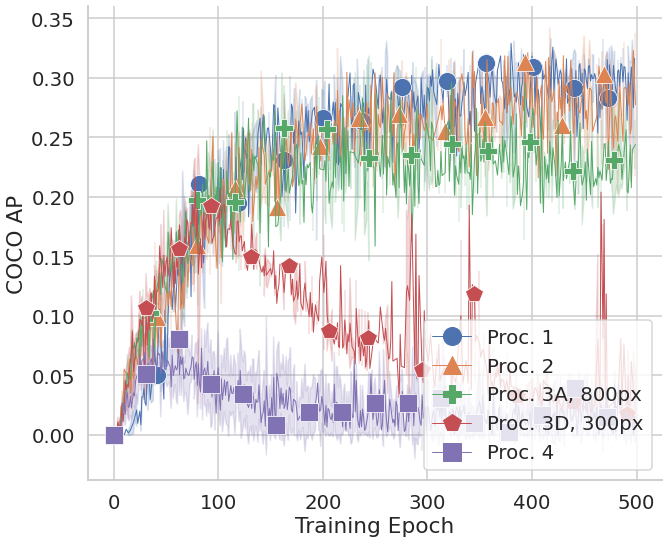

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

colors = sns.color_palette()
figsize = (10, 8)
markers = [
    'o', '^', "P", "p", 's'
]

size_kwargs = dict(
    height=figsize[1],
    aspect=figsize[0]/figsize[1],
    markevery=31,
    dashes=False,
    markers=markers,
)

sns.set(
    context='talk',
    style='whitegrid',
    font_scale=1.2,
    rc={
        'lines.linewidth': 1,
        'figure.figsize': figsize,
        'lines.markersize': 18,
    }
)


fig = sns.relplot(
    data=df[df[CROP_SIZE].isin([800, 300, -1])],
    x=EPOCH, y=COCO_AP, hue=PROC, kind='line',
    style=PROC, ci='sd',
    **size_kwargs
)
fig.legend.remove()
#fig.set(ylim=(0, 0.6))
#fig.set(xlim=(0, 400))
plt.legend(loc='lower right')
fig.savefig(fig_path / 'COCO_AP_proc_1_2_3_4.png')

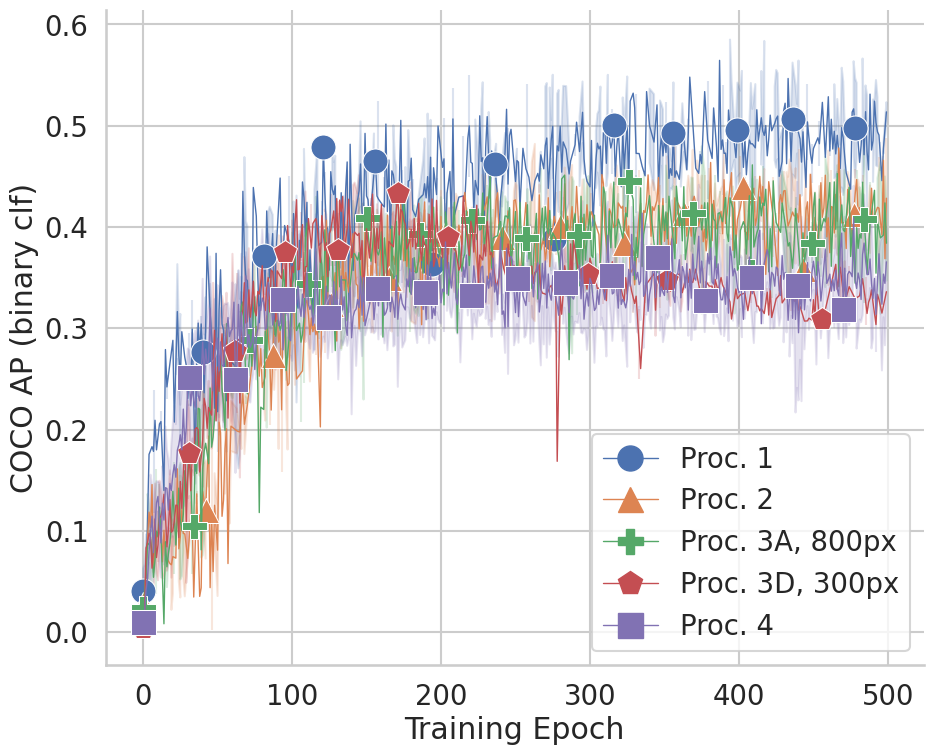

In [8]:
fig = sns.relplot(
    data=df[df[CROP_SIZE].isin([800, 300, -1])],
    x=EPOCH, y=COCO_AP_BIN, hue=PROC, kind='line',
    style=PROC, ci='sd',
    **size_kwargs
)
fig.legend.remove()
#fig.set(ylim=(0, 0.6))
#fig.set(xlim=(0, 400))
plt.legend(loc='lower right')
fig.savefig(fig_path / 'COCO_AP_binary_proc_1_2_3_4.png')

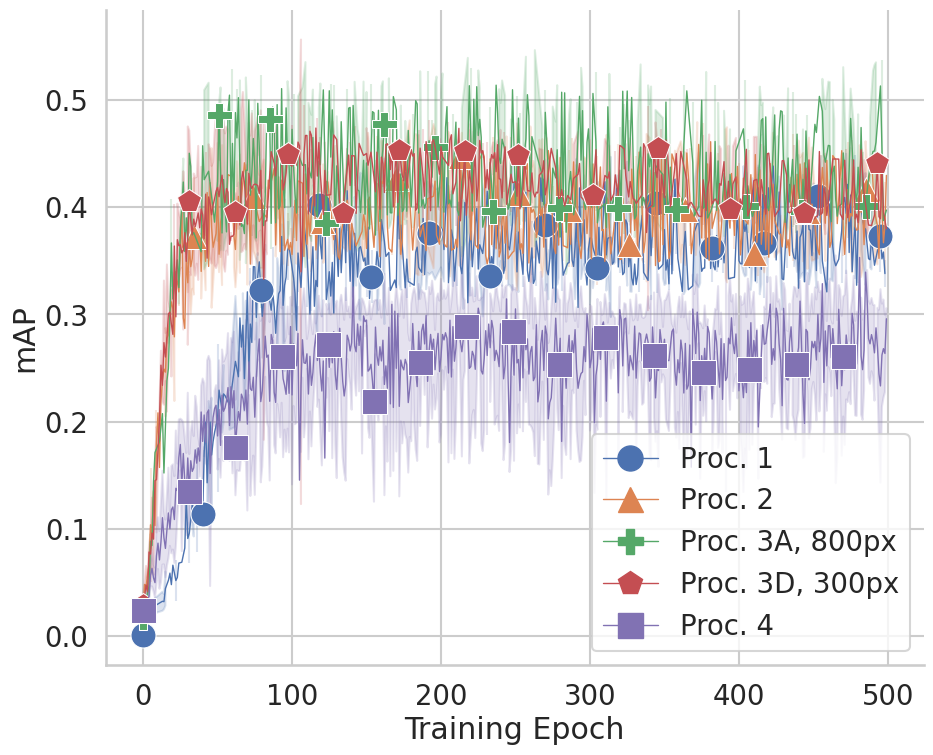

In [9]:
fig = sns.relplot(
    data=df[df[CROP_SIZE].isin([800, 300, -1])],
    x=EPOCH, y=RECOG_AP, hue=PROC, kind='line',
    style=PROC, ci='sd',
    **size_kwargs
)
fig.legend.remove()
#fig.set(ylim=(0, 0.6))
#fig.set(xlim=(0, 400))
plt.legend(loc='lower right')
fig.savefig(fig_path / 'mAP_proc_1_2_3_4.png')

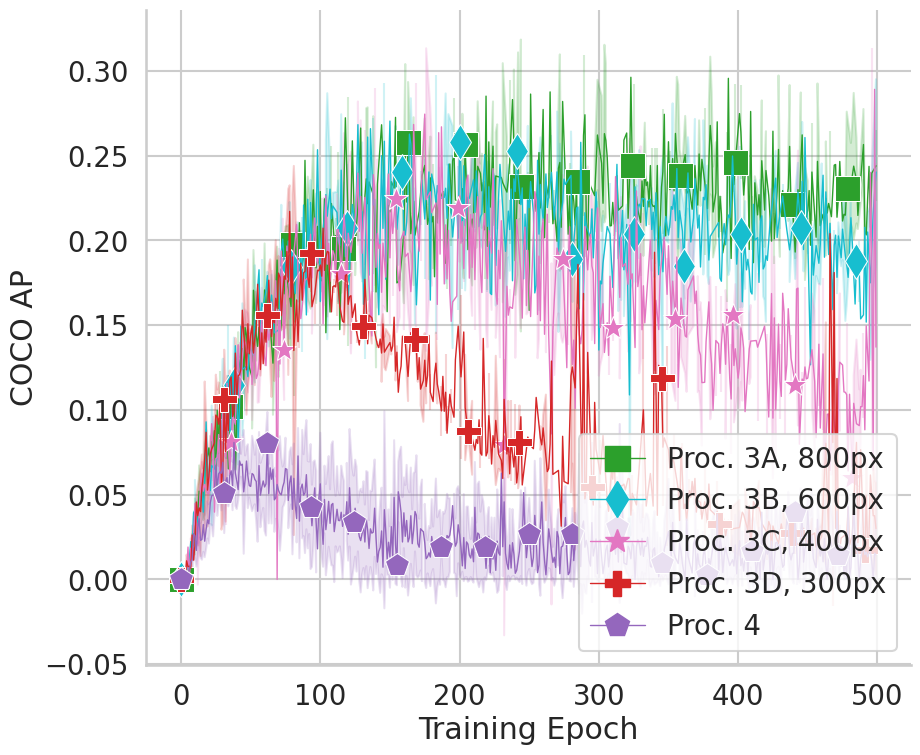

In [10]:
markers_3_4 = ['s', 'd', '*', 'P', 'p']
palette_3_4 = [colors[2], colors[-1], colors[6], colors[3], colors[4]]

proc_3_4_kwargs = {
    **size_kwargs,
    'markers': markers_3_4,
    'palette': palette_3_4
}

fig = sns.relplot(
    data=df[df[PROC].isin(PROCS_3_4)].sort_values(by=CROP_SIZE, ascending=False),
    x=EPOCH, y=COCO_AP, hue=PROC, kind='line', style=PROC,
    ci='sd', **proc_3_4_kwargs
)
fig.legend.remove()
#fig.set(ylim=(0, 0.6))
#fig.set(xlim=(0, 400))
plt.legend(loc='lower right')
fig.savefig(fig_path / 'COCO_AP_procs_3_4.png')

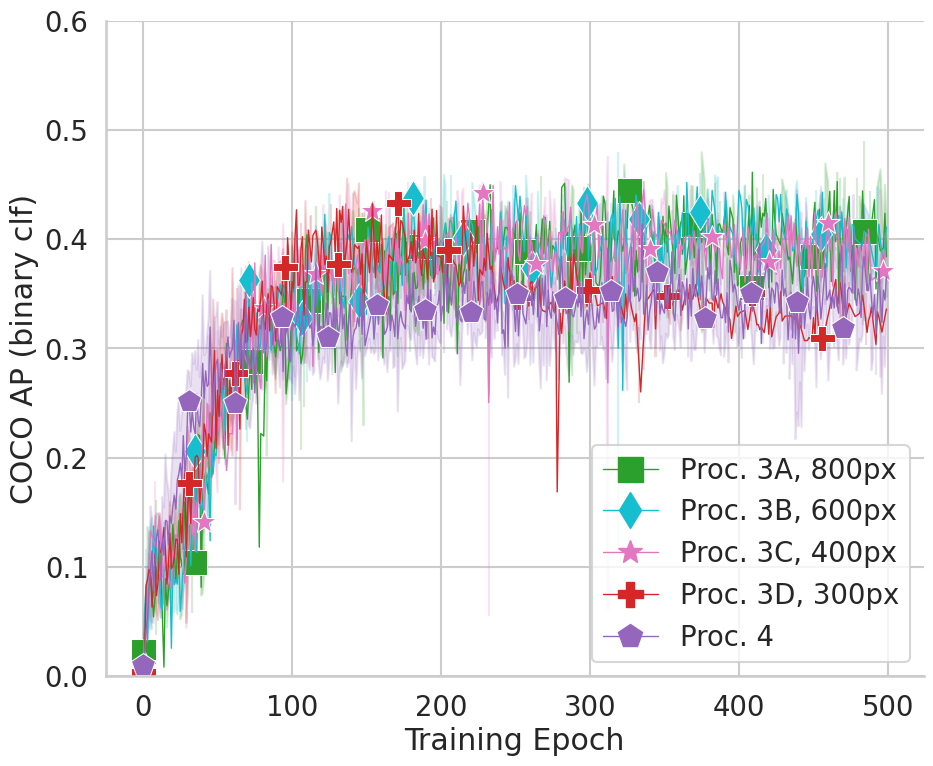

In [11]:
fig = sns.relplot(
    data=df[df[PROC].isin(PROCS_3_4)].sort_values(by=CROP_SIZE, ascending=False),
    x=EPOCH, y=COCO_AP_BIN, hue=PROC, kind='line', style=PROC,
    ci='sd', **proc_3_4_kwargs
)
fig.legend.remove()
fig.set(ylim=(0, 0.6))
#fig.set(xlim=(0, 400))
plt.legend(loc='lower right')
fig.savefig(fig_path / 'COCO_AP_binary_procs_3_4.png')

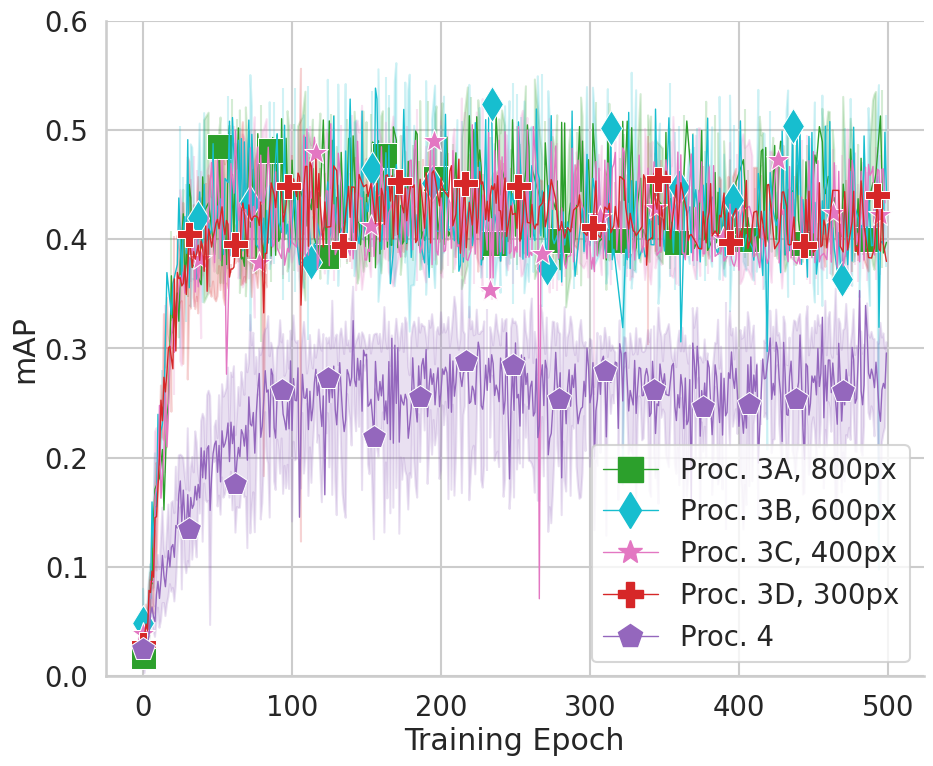

In [12]:
fig = sns.relplot(
    data=df[df[PROC].isin(PROCS_3_4)].sort_values(by=CROP_SIZE, ascending=False),
    x=EPOCH, y=RECOG_AP, hue=PROC, kind='line', style=PROC,
    ci='sd', **proc_3_4_kwargs
)
fig.legend.remove()
fig.set(ylim=(0, 0.6))
#fig.set(xlim=(0, 400))
plt.legend(loc='lower right')
fig.savefig(fig_path / 'mAP_procs_3_4_sizes.png')

# Only Proc. 4

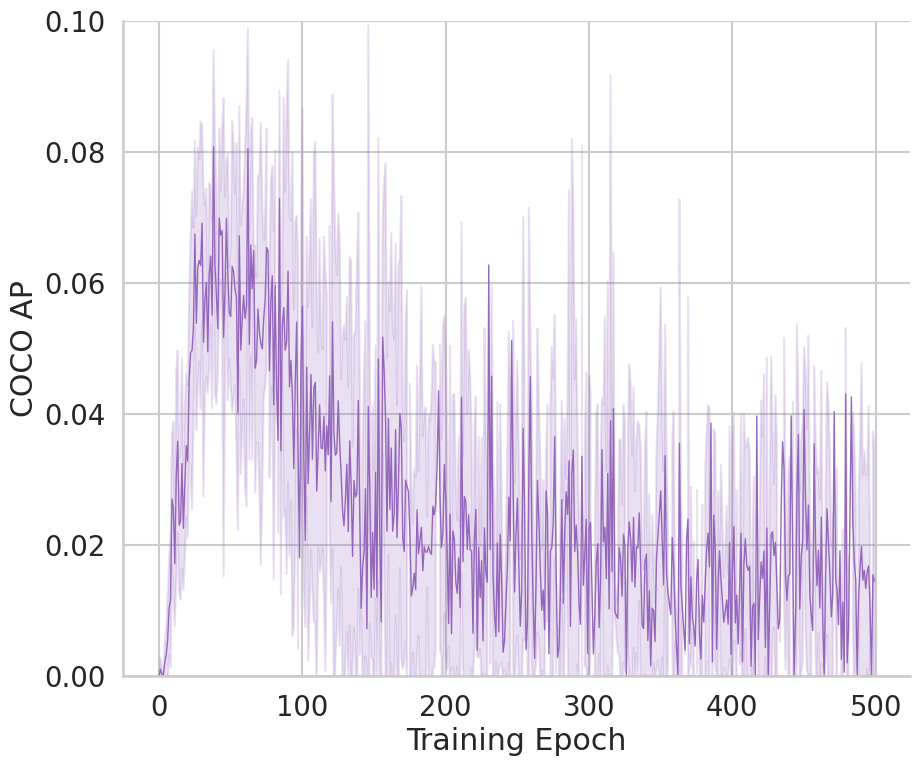

In [13]:
proc_4_kwargs = {
    **size_kwargs,
    'markers': None,
    'palette': [
        colors[4]
    ]
}

fig = sns.relplot(
    data=df[df[PROC] == PROC_4],
    x=EPOCH, y=COCO_AP, hue=PROC, kind='line', style=PROC,
    ci='sd', **proc_4_kwargs
)
fig.legend.remove()
fig.set(ylim=(0, 0.1))
#fig.set(xlim=(0, 400))
fig.savefig(fig_path / 'COCO_AP_proc_4.png')

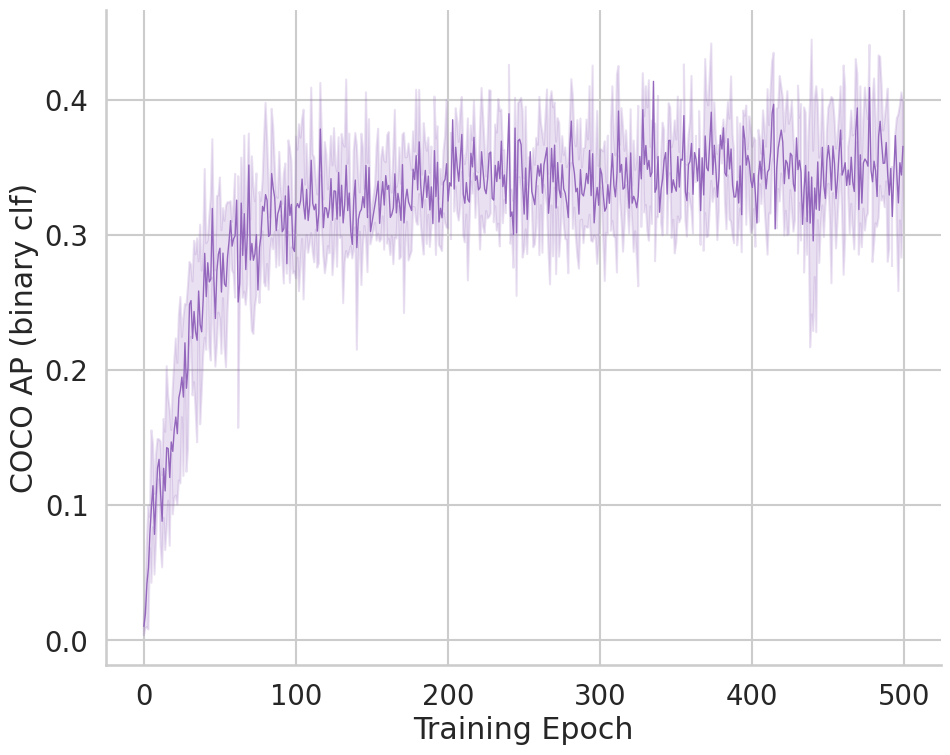

In [14]:
fig = sns.relplot(
    data=df[df[PROC] == PROC_4].sort_values(by=CROP_SIZE, ascending=False),
    x=EPOCH, y=COCO_AP_BIN, hue=PROC, kind='line', style=PROC,
    ci='sd', **proc_4_kwargs
)
fig.legend.remove()
#fig.set(ylim=(0, 0.6))
#fig.set(xlim=(0, 400))
fig.savefig(fig_path / 'COCO_AP_binary_proc_4.png')

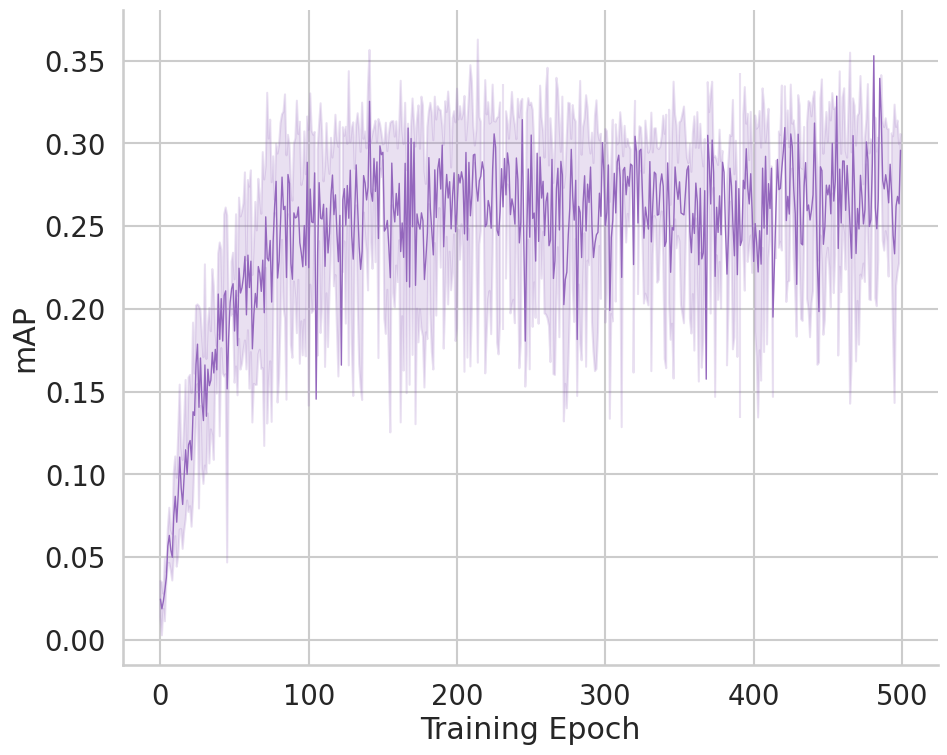

In [15]:
fig = sns.relplot(
    data=df[df[PROC] == PROC_4].sort_values(by=CROP_SIZE, ascending=False),
    x=EPOCH, y=RECOG_AP, hue=PROC, kind='line', style=PROC,
    ci='sd', **proc_4_kwargs
)
fig.legend.remove()
#fig.set(xlim=(0, 400))
fig.savefig(fig_path / 'mAP_proc_4.png')

# Only Proc. 1

In [16]:
proc_1_kwargs = {
    **size_kwargs,
    'markers': [markers[0], markers[-1]],
    'palette': [
        colors[0],
        colors[4]
    ]
}

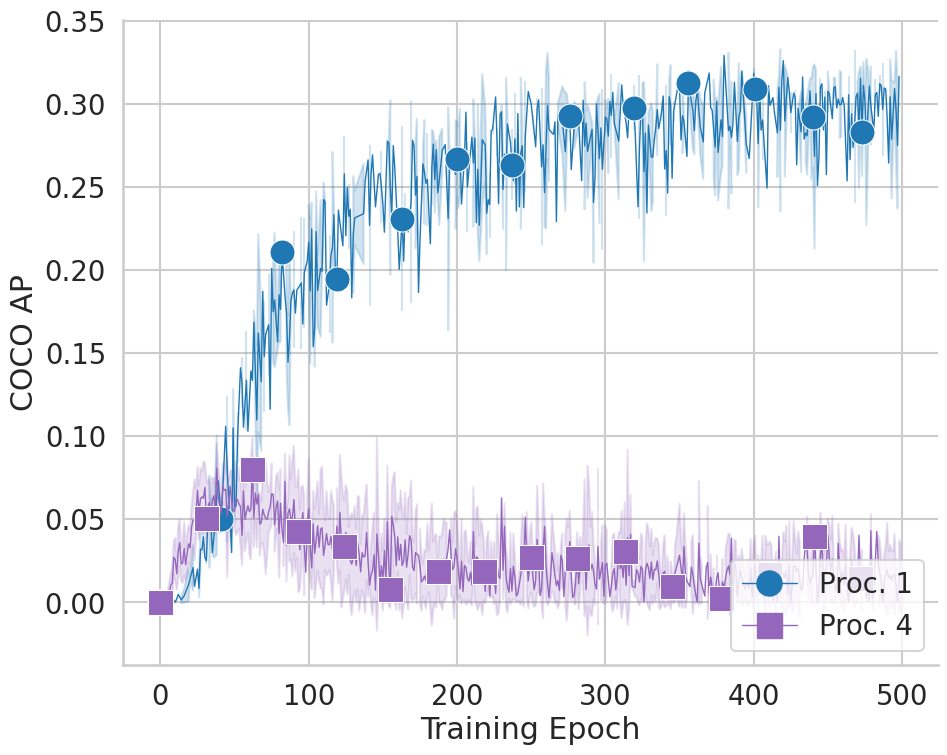

In [17]:
fig = sns.relplot(
    data=df[df[PROC].isin([PROC_1, PROC_4])],
    x=EPOCH, y=COCO_AP, hue=PROC, kind='line', style=PROC,
    ci='sd', **proc_1_kwargs
)
fig.legend.remove()
#fig.set(xlim=(0, 400))
plt.legend(loc='lower right')
fig.savefig(fig_path / 'COCO_AP_proc_1_4.png')

# Proc. 1 & 2

In [18]:
proc_1_2_kwargs = {
    **size_kwargs,
    'markers': [*markers[:2], markers[-1]],
    'palette': [*colors[:2], colors[4]]
}

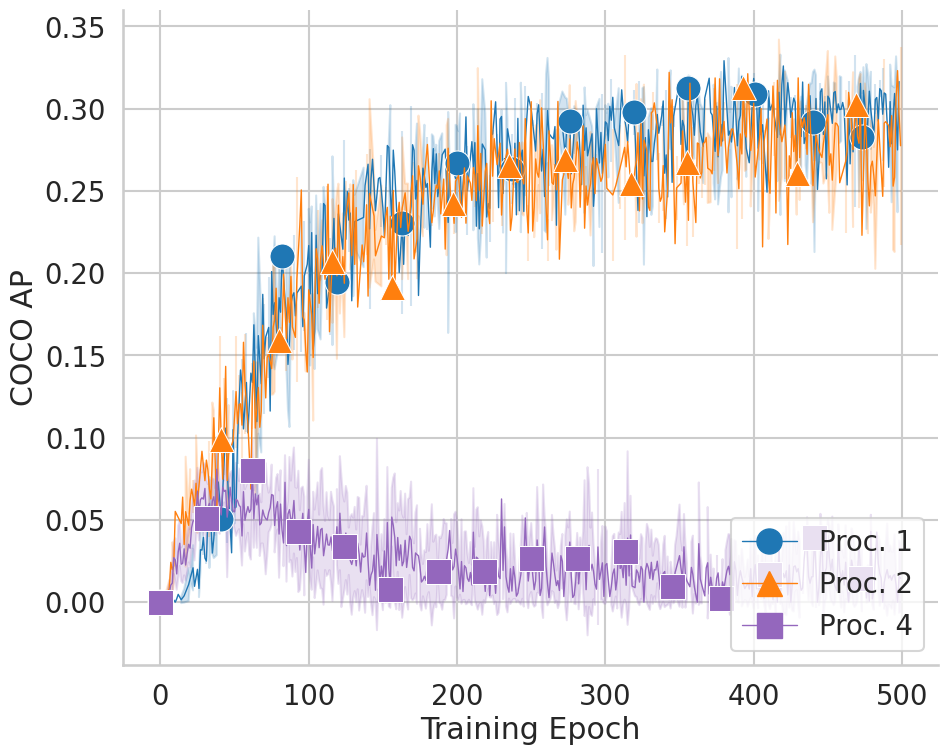

In [19]:
fig = sns.relplot(
    data=df[df[PROC].isin([PROC_1, PROC_2, PROC_4])],
    x=EPOCH, y=COCO_AP, hue=PROC, kind='line', style=PROC,
    ci='sd', **proc_1_2_kwargs
)
fig.legend.remove()
#fig.set(xlim=(0, 400))
plt.legend(loc='lower right')
fig.savefig(fig_path / 'COCO_AP_proc_1_2_4.png')

# Proc. 3

In [20]:
df[df[PROC].isin(PROCS_3_4)]

_step   COCO AP  Training Epoch  COCO AP (binary clf)       mAP  \
4043      251  0.000000               0                   NaN       NaN   
4044      536  0.000000               1                   NaN       NaN   
4045      821  0.000475               2                   NaN       NaN   
4046     1106  0.000000               3                   NaN       NaN   
4047     2246  0.015294               7                   NaN       NaN   
...       ...       ...             ...                   ...       ...   
17742  134177       NaN             480                   NaN  0.295384   
17743  135293       NaN             484                   NaN  0.294434   
17744  135851       NaN             486                   NaN  0.298110   
17745  136409       NaN             488                   NaN  0.300522   
17746  136688       NaN             489                   NaN  0.308278   

             Procedure  Crop size  val_fold  
4043   Proc. 3A, 800px        800         4  
4044   Proc. 3A, 800px        800         4  
4045   Proc. 3A, 800px        800         4  
4046   Proc. 3A, 800px        800         4  
4047   Proc. 3A, 800px        800         4  
...                ...        ...       ...  
17742          Proc. 4         -1         0  
17743          Proc. 4         -1         0  
17744          Proc. 4         -1         0  
17745          Proc. 4         -1         0  
17746          Proc. 4         -1         0  

[13704 rows x 8 columns]

In [21]:
markers

['o', '^', 'P', 'p', 's']

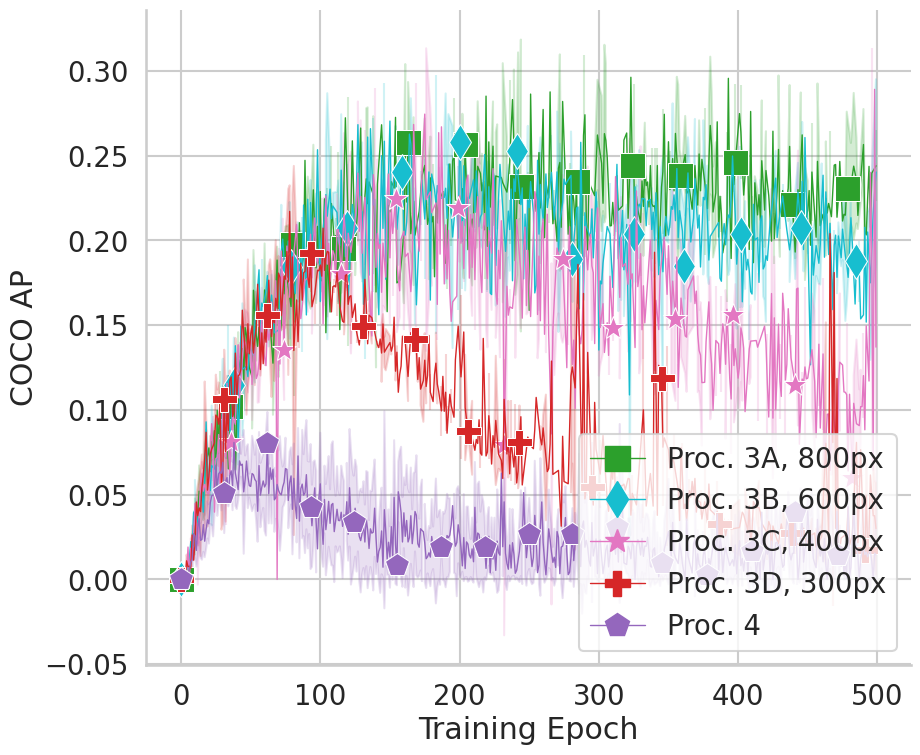

In [22]:
proc_3_kwargs = {
    **size_kwargs,
    'markers': markers_3_4,
    'palette': palette_3_4
}

fig = sns.relplot(
    data=df[df[PROC].isin(PROCS_3_4)],
    x=EPOCH, y=COCO_AP, hue=PROC, kind='line', style=PROC,
    ci='sd', **proc_3_kwargs
)
fig.legend.remove()
#fig.set(xlim=(0, 400))
plt.legend(loc='lower right')
fig.savefig(fig_path / 'COCO_AP_proc_3.png')

In [23]:
!zip -r imgs imgs

  adding: imgs/ (stored 0%)
  adding: imgs/COCO_AP_proc_4.png (deflated 1%)
  adding: imgs/COCO_AP_proc_1_2_4.png (deflated 2%)
  adding: imgs/COCO_AP_procs_3_4.png (deflated 1%)
  adding: imgs/COCO_AP_binary_proc_4.png (deflated 3%)
  adding: imgs/COCO_AP_proc_1_2_3_4.png (deflated 1%)
  adding: imgs/mAP_proc_4.png (deflated 2%)
  adding: imgs/COCO_AP_binary_proc_1_2_3_4.png (deflated 2%)
  adding: imgs/mAP_procs_3_4_sizes.png (deflated 1%)
  adding: imgs/COCO_AP_binary_procs_3_4.png (deflated 2%)
  adding: imgs/COCO_AP_proc_1_4.png (deflated 2%)
  adding: imgs/mAP_proc_1_2_3_4.png (deflated 1%)
  adding: imgs/COCO_AP_proc_3.png (deflated 1%)
